# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [5]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        keys_word = list(self.word2vec.keys())
        scores_data = np.zeros(len(keys_word))
        
        for ind, word in enumerate(keys_word):
            scores_data[ind] = self.score(w, word)
            
        inds_words = np.argsort(scores_data)[-K:]
        words_close = np.array(keys_word)[inds_words]
        # K most similar words: self.score  -  np.argsort 
        return(words_close)

    def score(self, w1, w2):
        vec1 = self.word2vec[w1]
        vec2 = self.word2vec[w2]
        
        score_cosine = vec1.dot(vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
        # cosine similarity: np.dot  -  np.linalg.norm
        return(score_cosine)


In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.684206402966922
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['feline' 'kitten' 'kitty' 'cats' 'cat']
['doggie' 'Dog' 'puppy' 'dogs' 'dog']
['doggies' 'Dogs' 'pooches' 'dog' 'dogs']
['berlin' 'london' 'Paris' 'france' 'paris']
['berlin' 'german' 'europe' 'austria' 'germany']


In [8]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                vect = []
                for ind, w in enumerate(sent):
                    try:
                        vect.append(self.w2v.word2vec[w])
                    except:
                        #print("not in the dataset : " + w)
                        pass
                vect = np.vstack(vect)
                sentemb.append(np.mean(vect, axis = 0))
                # mean of word vectors
            else:
                vect = []
                for ind, w in enumerate(sent):
                    try:
                        vect.append(self.w2v.word2vec[w]*idf[w])
                    except:
                        #print("not in the dataset : " + w)
                        pass
                vect = np.vstack(vect)
                sentemb.append(np.mean(vect, axis = 0))
                # idf-weighted mean of word vectors
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores_data = np.zeros(len(keys))
        for ind, sent in enumerate(keys):
            scores_data[ind] = self.score(np.array(query), np.array(sent), idf)
            
        inds_sent = np.argsort(scores_data)[-K:]
        sent_close = np.array(sentences)[inds_sent]
        print('phrases proches', sent_close)
        # K most similar words: self.score  -  np.argsort
        return(sent_close)

    def score(self, s1, s2, idf=False):
        if type(s1) == list:
            s1 = np.array(self.encode([s1], idf))
            s2 = np.array(self.encode([s2], idf)).transpose()
        score_cosine = s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
        # cosine similarity: use   np.dot  and  np.linalg.norm
        return(score_cosine)
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
            
        return(idf)

In [9]:
#w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = [] #list of list of words
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
        for line in f:
            sentences.append(line.split())
            
# Build idf scores for each word
s2v.build_idf(sentences)
idf = {} if True else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

phrases proches [list(['an', 'african', 'american', 'man', 'is', 'sitting', '.'])
 list(['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children', '.'])
 list(['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up', '.'])
 list(['an', 'african', 'american', 'man', 'smiling', '.'])
 list(['1', 'smiling', 'african', 'american', 'boy', '.'])]
[[0.57262589]]
phrases proches [list(['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children', '.'])
 list(['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up', '.'])
 list(['an', 'african', 'american', 'man', 'is', 'sitting', '.'])
 list(['an', 'african', 'american', 'man', 'smiling', '.'])
 list(['1', 'smiling', 'african', 'american', 'boy', '.'])]
[[0.47514509]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [10]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

def load_wordvec(fname, nmax):
        word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(word2vec)))
        return(word2vec)
        
french_vec = os.path.join(PATH_TO_DATA, 'wiki.fr.vec')
engl_vec = os.path.join(PATH_TO_DATA, 'wiki.en.vec')
d = 300
nmax = 50000
french_w2v = load_wordvec(french_vec, nmax)
engl_w2v = load_wordvec(engl_vec, nmax)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [11]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
def intersection_linear_complex(lst1, lst2): 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return(lst3)

french_words = [*french_w2v.keys()]
english_words = [*engl_w2v.keys()]

common_words = intersection_linear_complex(french_words, english_words)

french_common = np.zeros((d, len(common_words)))
english_common = np.zeros((d, len(common_words)))
for ind, word in enumerate(common_words):
    french_common[:,ind] = french_w2v[word]
    english_common[:,ind] = engl_w2v[word]
    
french = np.zeros((d, len(french_words)))
english = np.zeros((d, len(english_words)))
ind_to_french = {}
ind_to_english = {}
for ind, word in enumerate(french_words):
    french[:,ind] = french_w2v[word]
    ind_to_french[ind] = word
for ind, word in enumerate(english_words): 
    english[:,ind] = engl_w2v[word]
    ind_to_english[ind] = word
    

In [12]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
import scipy.linalg
U, s, Vh = scipy.linalg.svd(english_common.dot(french_common.transpose()), full_matrices=False)

W_opt = U.dot(Vh)


In [13]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
from scipy import spatial

english_hat = W_opt.dot(french)
french_hat = (W_opt.transpose()).dot(english)
words_french = ['ici', 'amis', 'mais', 'crayon', 'aide', 'sanctuaire']
words_english = ['doctor', 'she', 'why', 'london','friend','friends']

print("English to French")
for word in words_english:
    dist_english_hat = scipy.spatial.distance_matrix(english_hat.transpose(), engl_w2v[word].reshape((1,-1)))
    word_closest = np.argmin(dist_english_hat)
    print(word + " : " + ind_to_french[word_closest])

print("")
print("Français à l'anglais")
for word in words_french:
    dist_french_hat = scipy.spatial.distance_matrix(french_hat.transpose(), french_w2v[word].reshape((1,-1)))
    word_closest = np.argmin(dist_french_hat)
    print(word + " : " + ind_to_english[word_closest])
    

English to French
doctor : docteur
she : elle
why : pourquoi
london : londres
friend : ami
friends : amis

Français à l'anglais
ici : here
amis : friends
mais : but
crayon : pencil
aide : help
sanctuaire : shrine


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [14]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_sentences(fname):
        Bov_nb = []
        Bov_sent = []
        with io.open(fname, encoding='utf-8') as f:
            for i, line in enumerate(f):
                words = line.split(' ')
                words[-1] = words[-1].strip()
                if words[0].isdigit():
                    Bov_nb.append(words[0])
                    Bov_sent.append(words[1:])
                else:
                    Bov_sent.append(words)
        print('Loaded %s pretrained word vectors : ' + str(len(Bov_sent)) + " = " + str(len(Bov_nb)))
        return(Bov_nb, Bov_sent)
    
train_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train')
dev_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev')
test_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X')

train_sentences_list = load_sentences(train_BoV_file)
dev_sentences_list = load_sentences(dev_BoV_file)
test_sentences_list = load_sentences(test_BoV_file)


Loaded %s pretrained word vectors : 8544 = 8544
Loaded %s pretrained word vectors : 1101 = 1101
Loaded %s pretrained word vectors : 2210 = 1


In [15]:
# 2 - Encode sentences with the BoV model above

use_idf = False

if use_idf:
    idf_train = s2v.build_idf(train_sentences_list[1])
    idf_dev = s2v.build_idf(dev_sentences_list[1])
else:
    idf_train = False
    idf_dev = False
    
sentences_train_array = s2v.encode(train_sentences_list[1], idf_train)
nb_train_array = np.array(train_sentences_list[0]).astype(int)
print("Training shape : " + str(sentences_train_array.shape) + " and " + str(nb_train_array.shape))


sentences_dev_array = s2v.encode(dev_sentences_list[1], idf_dev)
nb_dev_array = np.array(dev_sentences_list[0]).astype(int)
print("Dev shape : " + str(sentences_dev_array.shape) + " and " + str(nb_dev_array.shape))

sentences_test_array = s2v.encode(test_sentences_list[1])


Training shape : (8544, 300) and (8544,)
Dev shape : (1101, 300) and (1101,)


In [16]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(sentences_train_array, nb_train_array)

print("Train score : " + str(clf.score(sentences_train_array, nb_train_array)))
print("Dev score : " + str(clf.score(sentences_dev_array, nb_dev_array)))


Train score : 0.48829588014981273
Dev score : 0.43142597638510444


In [17]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(nb_train_array, clf.predict(sentences_train_array))

array([[ 274,  631,   52,  120,   15],
       [ 107, 1497,  144,  429,   41],
       [  48,  677,  274,  573,   52],
       [  18,  387,  102, 1592,  223],
       [   8,   94,   24,  627,  535]], dtype=int64)

In [18]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

with open('logreg_bov_y_test_sst.txt', 'w') as f:
    prediction = clf.predict(sentences_test_array)
    for item in prediction.tolist():
        f.write("%s\n" % item)

In [20]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn import svm
clf = svm.SVC().fit(sentences_train_array, nb_train_array)
with open('svm_bov_y_test_sst.txt', 'w') as f:
    prediction = clf.predict(sentences_test_array)
    for item in prediction.tolist():
        f.write("%s\n" % item)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import keras

C:\Users\anatole parre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
# 1 - Load train/dev/test sets of SST
train_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train')
dev_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev')
test_BoV_file = os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X')

train_sentences_list = load_sentences(train_BoV_file)
dev_sentences_list = load_sentences(dev_BoV_file)
test_sentences_list = load_sentences(test_BoV_file)

Loaded %s pretrained word vectors : 8544 = 8544
Loaded %s pretrained word vectors : 1101 = 1101
Loaded %s pretrained word vectors : 2210 = 1


In [22]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

string_sentences_list = ' '.join(str(r) for v in train_sentences_list[1] for r in v)

set_words = set(keras.preprocessing.text.text_to_word_sequence(string_sentences_list))
train_size = len(set_words)
print("Number of different words : " + str(train_size))
train_size = 8000

def sentences_list_to_int_sentences_list(sentences_list, train_size):
    int_sentences_list = []
    for v in sentences_list[1]:
        string_sent = ' '.join(v)
        int_sentences_list.append(keras.preprocessing.text.one_hot(string_sent, train_size, filters="#$%&()*+,-./:;<=>?@[\]^_`{|}~", lower=True, split=" ")) #filters=base_filter(), 
    return(int_sentences_list)

int_train_sentences_list = sentences_list_to_int_sentences_list(train_sentences_list, train_size)
int_dev_sentences_list = sentences_list_to_int_sentences_list(dev_sentences_list, train_size)
int_test_sentences_list = sentences_list_to_int_sentences_list(test_sentences_list, train_size)

print("Training size : " + str(len(int_train_sentences_list)))
print("Dev size : " + str(len(int_dev_sentences_list)))
print("Test size : " + str(len(int_test_sentences_list)))

Number of different words : 15337
Training size : 8544
Dev size : 1101
Test size : 2210


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [23]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

word_embedding_d = 20

array_glob_sentences = keras.preprocessing.sequence.pad_sequences(int_train_sentences_list+int_dev_sentences_list+int_test_sentences_list, maxlen=word_embedding_d, dtype='int32')

array_train_sentences = array_glob_sentences[:len(int_train_sentences_list)]
array_dev_sentences = array_glob_sentences[len(int_train_sentences_list):len(int_train_sentences_list)+len(int_dev_sentences_list)]
array_test_sentences = array_glob_sentences[len(int_train_sentences_list)+len(int_dev_sentences_list):]

def compute_train_set(sentences_list):
    array_nb = np.zeros((len(sentences_list[0]), 5))
    for ind, classe in enumerate(sentences_list[0]):
        array_nb[ind, int(classe)] = 1
    return(array_nb)

array_train_nb = compute_train_set(train_sentences_list)
array_dev_nb = compute_train_set(dev_sentences_list)

print("Training size : " + str(array_train_sentences.shape))
print("Dev size : " + str(array_dev_sentences.shape))
print("Test size : " + str(array_test_sentences.shape))

Training size : (8544, 20)
Dev size : (1101, 20)
Test size : (2210, 20)


## 4.2 - Design and train your model

In [24]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = word_embedding_d  # word embedding dimension
nhid       = 20  # number of hidden units in the LSTM
vocab_size = train_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


C:\Users\anatole parre\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, dropout=0.2, recurrent_dropout=0.2)`
  app.launch_new_instance()


In [25]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 163,385
Trainable params: 163,385
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 120
n_epochs = 10

x_train = array_train_sentences
y_train = array_train_nb
x_val = array_dev_sentences
y_val = array_dev_nb

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 17s 2ms/step - loss: 1.5945 - acc: 0.2754 - val_loss: 1.5716 - val_acc: 0.2534A: 0s - loss: 1.5952 - acc: 0.27
Epoch 2/10
8544/8544 [==============================] - 7s 794us/step - loss: 1.5621 - acc: 0.2849 - val_loss: 1.5627 - val_acc: 0.3070
Epoch 3/10
8544/8544 [==============================] - 7s 867us/step - loss: 1.5237 - acc: 0.3429 - val_loss: 1.4970 - val_acc: 0.3569
Epoch 4/10
8544/8544 [==============================] - 8s 909us/step - loss: 1.3988 - acc: 0.3930 - val_loss: 1.4298 - val_acc: 0.3760
Epoch 5/10
8544/8544 [==============================] - 8s 896us/step - loss: 1.2700 - acc: 0.4441 - val_loss: 1.4450 - val_acc: 0.3706
Epoch 6/10
8544/8544 [==============================] - 9s 1ms/step - loss: 1.1635 - acc: 0.4829 - val_loss: 1.4629 - val_acc: 0.3706
Epoch 7/10
8544/8544 [==============================] - 9s 1ms/step - loss: 1.0697 - acc: 0.5310 - val_loss

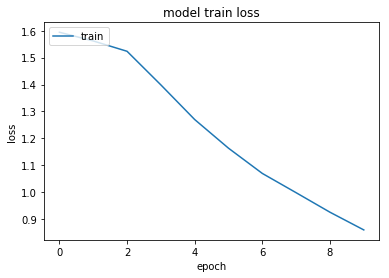

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('train_results.jpg')
plt.show()

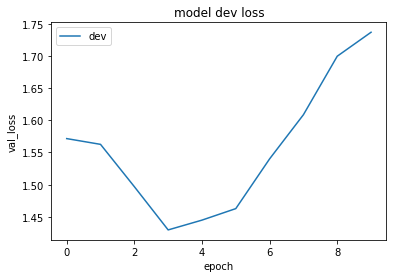

In [40]:
plt.plot(history.history['val_loss'])
plt.title('model dev loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['dev'], loc='upper left')
plt.savefig('dev_results.jpg')
plt.show()

In [41]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
with open('logreg_lstm_y_test_sst.txt', 'w') as f:
    prediction = model.predict(array_test_sentences)
    for item in prediction.tolist():
        f.write("%s\n" % item)

## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
